# Importing libraries

In [1]:
import numpy as np
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading and Preprocessing

In [2]:
# Read dataset from .mat file
file_path = 's32.mat'
mat_data = sio.loadmat(file_path)

# Show the shape of data
data = mat_data['data']
labels = mat_data['labels']
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

# Preprocessing
# Flatten the data for normalization
data_flattened = data.reshape(data.shape[0], -1)
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_flattened)

# Binarize labels
thresholds = np.mean(labels, axis=0)
labels_binarized = (labels > thresholds).astype(int)
#print(f"Binarized Labels:\n{labels_binarized}")

# Check the distribution of binarized labels
label_sums = np.sum(labels_binarized, axis=0)
label_distribution = dict(zip(['Valence', 'Arousal', 'Dominance', 'Liking'], label_sums))
print(label_distribution)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data_normalized, labels_binarized, test_size=0.2, random_state=42)

Data shape: (40, 40, 8064)
Labels shape: (40, 4)
{'Valence': 18, 'Arousal': 25, 'Dominance': 26, 'Liking': 22}


# Feature Extraction

In [3]:
def extract_features(data, num_channels=40, data_points_per_channel=8064):
    features = []
    for trial in data:
        trial_features = []
        for channel in range(num_channels):
            channel_data = trial[channel * data_points_per_channel:(channel + 1) * data_points_per_channel]
            trial_features.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.min(channel_data),
                np.max(channel_data)
            ])
        features.append(trial_features)
    return np.array(features)

X_train_rf = extract_features(X_train, num_channels=40, data_points_per_channel=8064)
X_test_rf = extract_features(X_test, num_channels=40, data_points_per_channel=8064)
print(f"Extracted Features:\n{X_train_rf}")

Extracted Features:
[[-5.76288669e-03  8.20405163e-01 -3.50968708e+00 ...  6.17817547e-01
  -2.18651442e+00  4.83107933e+00]
 [ 7.83969388e-03  1.08589462e+00 -5.63682020e+00 ...  7.88591288e-01
  -2.57809810e+00  5.12235591e+00]
 [-4.62411394e-03  8.04075583e-01 -3.91861484e+00 ...  7.87600268e-01
  -3.18757694e+00  4.68873486e+00]
 ...
 [-1.06872703e-03  8.10779436e-01 -3.77428758e+00 ...  8.53787859e-01
  -3.12476724e+00  4.67787859e+00]
 [ 6.47677528e-03  7.73025712e-01 -4.43868386e+00 ...  6.74134677e-01
  -2.16520169e+00  4.60643537e+00]
 [ 1.11817416e-02  1.05456371e+00 -5.62088030e+00 ...  6.72186859e-01
  -2.00946712e+00  4.86954784e+00]]


# Train and Evaluate Models for Valence

Random Forest Accuracy (Balanced for Valence): 0.625
Classification Report (Random Forest for Valence):
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.80      0.67      0.73         6

    accuracy                           0.62         8
   macro avg       0.57      0.58      0.56         8
weighted avg       0.68      0.62      0.65         8



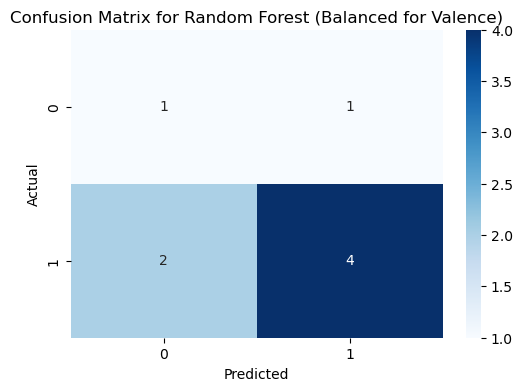

In [4]:
# Extract single label (Valence)
y_train_valence = y_train[:, 0]
y_test_valence = y_test[:, 0]

# Use SMOTE to balance the dataset for Valence label
sm = SMOTE(random_state=42)
X_train_balanced_valence, y_train_balanced_valence = sm.fit_resample(X_train_rf, y_train_valence)

# Apply Random Forest model on balanced data
rf_clf_balanced_valence = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_balanced_valence.fit(X_train_balanced_valence, y_train_balanced_valence)
y_pred_rf_balanced_valence = rf_clf_balanced_valence.predict(X_test_rf)
rf_accuracy_balanced_valence = accuracy_score(y_test_valence, y_pred_rf_balanced_valence)
print(f'Random Forest Accuracy (Balanced for Valence): {rf_accuracy_balanced_valence}')
print(f'Classification Report (Random Forest for Valence):\n{classification_report(y_test_valence, y_pred_rf_balanced_valence)}')

# Confusion Matrix for Random Forest (Balanced for Valence)
conf_matrix_rf_balanced_valence = confusion_matrix(y_test_valence, y_pred_rf_balanced_valence)
#print(f'Confusion Matrix for Random Forest (Balanced for Valence):\n{conf_matrix_rf_balanced_valence}')

# Plot Confusion Matrix for Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf_balanced_valence, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest (Balanced for Valence)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




Logistic Regression Accuracy (Balanced for Valence): 0.75
Classification Report (Logistic Regression for Valence):
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.67      0.80         6

    accuracy                           0.75         8
   macro avg       0.75      0.83      0.73         8
weighted avg       0.88      0.75      0.77         8



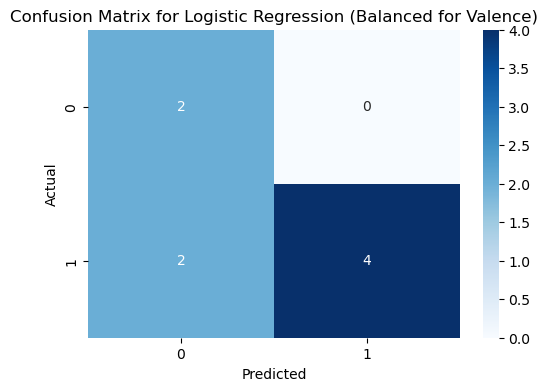

In [5]:
# Apply Logistic Regression model
lr_clf_valence = LogisticRegression(max_iter=1000, random_state=42)
lr_clf_valence.fit(X_train_balanced_valence, y_train_balanced_valence)
y_pred_lr_valence = lr_clf_valence.predict(X_test_rf)
lr_accuracy_valence = accuracy_score(y_test_valence, y_pred_lr_valence)
print(f'Logistic Regression Accuracy (Balanced for Valence): {lr_accuracy_valence}')
print(f'Classification Report (Logistic Regression for Valence):\n{classification_report(y_test_valence, y_pred_lr_valence)}')

# Confusion Matrix for Logistic Regression (Balanced for Valence)
conf_matrix_lr_valence = confusion_matrix(y_test_valence, y_pred_lr_valence)
#print(f'Confusion Matrix for Logistic Regression (Balanced for Valence):\n{conf_matrix_lr_valence}')

# Plot Confusion Matrix for Logistic Regression
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lr_valence, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression (Balanced for Valence)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Train and Evaluate Models for Arousal

Random Forest Accuracy (Balanced for Arousal): 0.625
Classification Report (Random Forest for Arousal):
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.60      0.75      0.67         4

    accuracy                           0.62         8
   macro avg       0.63      0.62      0.62         8
weighted avg       0.63      0.62      0.62         8



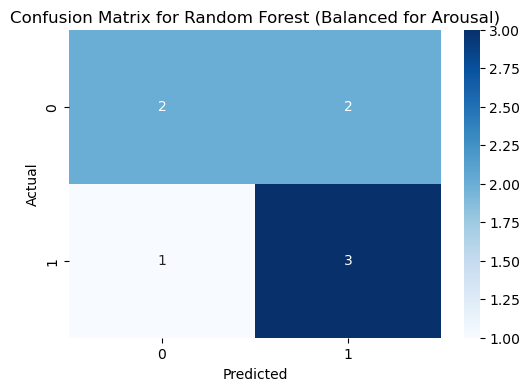

In [6]:
# Extract single label (Arousal)
y_train_arousal = y_train[:, 1]
y_test_arousal = y_test[:, 1]

# Use SMOTE to balance the dataset for Arousal label
X_train_balanced_arousal, y_train_balanced_arousal = sm.fit_resample(X_train_rf, y_train_arousal)

# Apply Random Forest model on balanced data
rf_clf_balanced_arousal = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_balanced_arousal.fit(X_train_balanced_arousal, y_train_balanced_arousal)
y_pred_rf_balanced_arousal = rf_clf_balanced_arousal.predict(X_test_rf)
rf_accuracy_balanced_arousal = accuracy_score(y_test_arousal, y_pred_rf_balanced_arousal)
print(f'Random Forest Accuracy (Balanced for Arousal): {rf_accuracy_balanced_arousal}')
print(f'Classification Report (Random Forest for Arousal):\n{classification_report(y_test_arousal, y_pred_rf_balanced_arousal)}')

# Confusion Matrix for Random Forest (Balanced for Arousal)
conf_matrix_rf_balanced_arousal = confusion_matrix(y_test_arousal, y_pred_rf_balanced_arousal)
#print(f'Confusion Matrix for Random Forest (Balanced for Arousal):\n{conf_matrix_rf_balanced_arousal}')

# Plot Confusion Matrix for Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf_balanced_arousal, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest (Balanced for Arousal)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Logistic Regression Accuracy (Balanced for Arousal): 0.5
Classification Report (Logistic Regression for Arousal):
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.50      0.75      0.60         4

    accuracy                           0.50         8
   macro avg       0.50      0.50      0.47         8
weighted avg       0.50      0.50      0.47         8



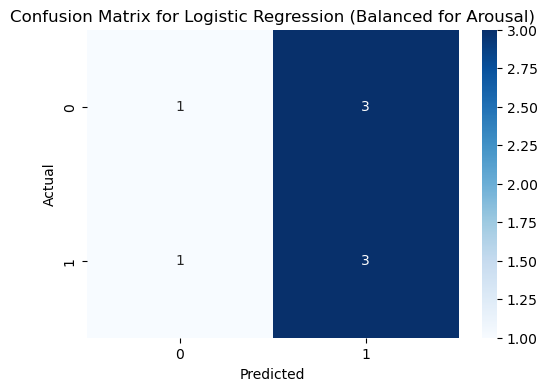

In [7]:
# Apply Logistic Regression model
lr_clf_arousal = LogisticRegression(max_iter=1000, random_state=42)
lr_clf_arousal.fit(X_train_balanced_arousal, y_train_balanced_arousal)
y_pred_lr_arousal = lr_clf_arousal.predict(X_test_rf)
lr_accuracy_arousal = accuracy_score(y_test_arousal, y_pred_lr_arousal)
print(f'Logistic Regression Accuracy (Balanced for Arousal): {lr_accuracy_arousal}')
print(f'Classification Report (Logistic Regression for Arousal):\n{classification_report(y_test_arousal, y_pred_lr_arousal)}')
# Confusion Matrix for Logistic Regression (Balanced for Arousal)
conf_matrix_lr_arousal = confusion_matrix(y_test_arousal, y_pred_lr_arousal)
# Plot Confusion Matrix for Logistic Regression
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lr_arousal, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression (Balanced for Arousal)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Train and Evaluate Models for Dominance

Random Forest Accuracy (Balanced for Dominance): 0.75
Classification Report (Random Forest for Dominance):
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.83      0.83      0.83         6

    accuracy                           0.75         8
   macro avg       0.67      0.67      0.67         8
weighted avg       0.75      0.75      0.75         8



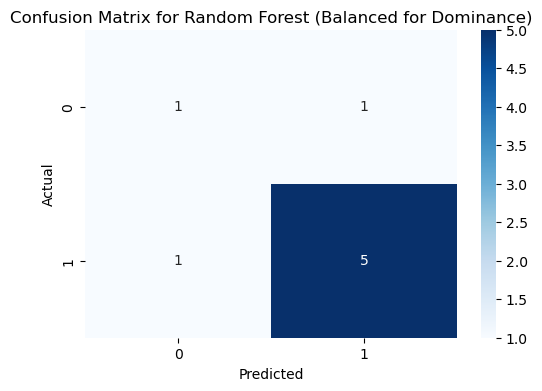

In [8]:
# Extract single label (Dominance)
y_train_dominance = y_train[:, 2]
y_test_dominance = y_test[:, 2]

# Use SMOTE to balance the dataset for Dominance label
X_train_balanced_dominance, y_train_balanced_dominance = sm.fit_resample(X_train_rf, y_train_dominance)

# Apply Random Forest model on balanced data
rf_clf_balanced_dominance = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_balanced_dominance.fit(X_train_balanced_dominance, y_train_balanced_dominance)
y_pred_rf_balanced_dominance = rf_clf_balanced_dominance.predict(X_test_rf)
rf_accuracy_balanced_dominance = accuracy_score(y_test_dominance, y_pred_rf_balanced_dominance)
print(f'Random Forest Accuracy (Balanced for Dominance): {rf_accuracy_balanced_dominance}')
print(f'Classification Report (Random Forest for Dominance):\n{classification_report(y_test_dominance, y_pred_rf_balanced_dominance)}')
# Confusion Matrix for Random Forest (Balanced for Dominance)
conf_matrix_rf_balanced_dominance = confusion_matrix(y_test_dominance, y_pred_rf_balanced_dominance)
# Plot Confusion Matrix for Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf_balanced_dominance, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest (Balanced for Dominance)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Logistic Regression Accuracy (Balanced for Dominance): 0.75
Classification Report (Logistic Regression for Dominance):
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.67      0.80         6

    accuracy                           0.75         8
   macro avg       0.75      0.83      0.73         8
weighted avg       0.88      0.75      0.77         8



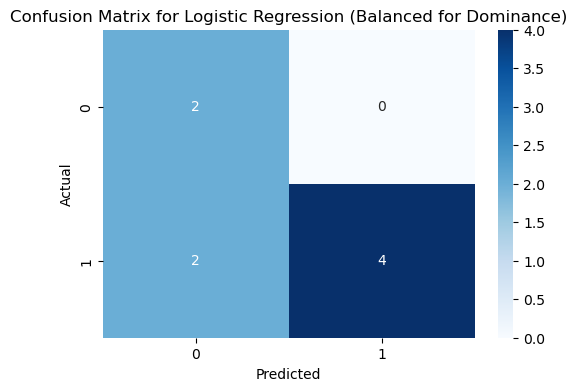

In [9]:
# Apply Logistic Regression model
lr_clf_dominance = LogisticRegression(max_iter=1000, random_state=42)
lr_clf_dominance.fit(X_train_balanced_dominance, y_train_balanced_dominance)
y_pred_lr_dominance = lr_clf_dominance.predict(X_test_rf)
lr_accuracy_dominance = accuracy_score(y_test_dominance, y_pred_lr_dominance)
print(f'Logistic Regression Accuracy (Balanced for Dominance): {lr_accuracy_dominance}')
print(f'Classification Report (Logistic Regression for Dominance):\n{classification_report(y_test_dominance, y_pred_lr_dominance)}')

# Confusion Matrix for Logistic Regression (Balanced for Dominance)
conf_matrix_lr_dominance = confusion_matrix(y_test_dominance, y_pred_lr_dominance)
# Plot Confusion Matrix for Logistic Regression
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lr_dominance, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression (Balanced for Dominance)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Train and Evaluate Models for Liking

Random Forest Accuracy (Balanced for Liking): 0.875
Classification Report (Random Forest for Liking):
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8



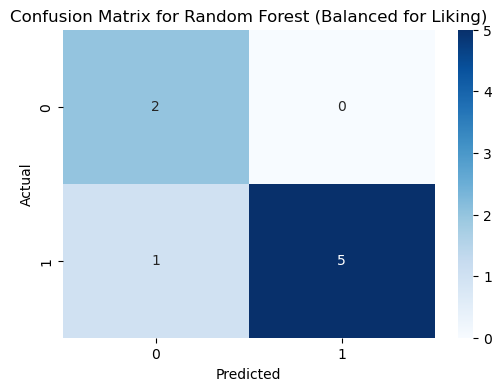

In [10]:
# Extract single label (Liking)
y_train_liking = y_train[:, 3]
y_test_liking = y_test[:, 3]

# Use SMOTE to balance the dataset for Liking label
X_train_balanced_liking, y_train_balanced_liking = sm.fit_resample(X_train_rf, y_train_liking)

# Apply Random Forest model on balanced data
rf_clf_balanced_liking = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_balanced_liking.fit(X_train_balanced_liking, y_train_balanced_liking)
y_pred_rf_balanced_liking = rf_clf_balanced_liking.predict(X_test_rf)
rf_accuracy_balanced_liking = accuracy_score(y_test_liking, y_pred_rf_balanced_liking)
print(f'Random Forest Accuracy (Balanced for Liking): {rf_accuracy_balanced_liking}')
print(f'Classification Report (Random Forest for Liking):\n{classification_report(y_test_liking, y_pred_rf_balanced_liking)}')
# Confusion Matrix for Random Forest (Balanced for Liking)
conf_matrix_rf_balanced_liking = confusion_matrix(y_test_liking, y_pred_rf_balanced_liking)
# Plot Confusion Matrix for Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf_balanced_liking, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest (Balanced for Liking)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




Logistic Regression Accuracy (Balanced for Liking): 0.75
Classification Report (Logistic Regression for Liking):
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.67      0.80         6

    accuracy                           0.75         8
   macro avg       0.75      0.83      0.73         8
weighted avg       0.88      0.75      0.77         8



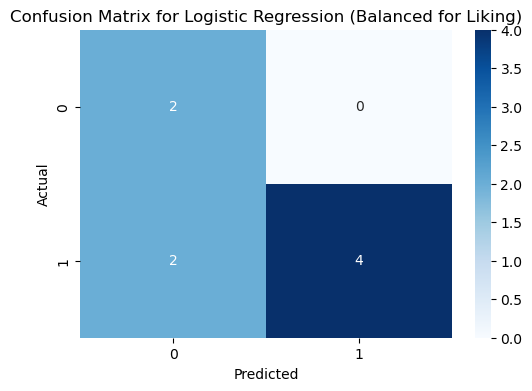

In [11]:
# Apply Logistic Regression model
lr_clf_liking = LogisticRegression(max_iter=1000, random_state=42)
lr_clf_liking.fit(X_train_balanced_liking, y_train_balanced_liking)
y_pred_lr_liking = lr_clf_liking.predict(X_test_rf)
lr_accuracy_liking = accuracy_score(y_test_liking, y_pred_lr_liking)
print(f'Logistic Regression Accuracy (Balanced for Liking): {lr_accuracy_liking}')
print(f'Classification Report (Logistic Regression for Liking):\n{classification_report(y_test_liking, y_pred_lr_liking)}')
# Confusion Matrix for Logistic Regression (Balanced for Liking)
conf_matrix_lr_liking = confusion_matrix(y_test_liking, y_pred_lr_liking)
# Plot Confusion Matrix for Logistic Regression
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lr_liking, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression (Balanced for Liking)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()